In [153]:
import mlrose_hiive as mlrose
import numpy as np
import math
from mlrose_hiive import GeomDecay
from dataclasses import dataclass
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Setup

tail(b, x) is the number of trailing b’s in x;

head(b, x) is the number of leading b’s in x;

R(x, T) = n, if tail(0, x) > T and head(1, x) > T; and

R(x, T) = 0, otherwise.

Fitness(x, T) = \max(tail(0, x), head(1, x)) + R(x, T)

In [185]:
t_pct = .15
length = 65

def get_peaks_optimal(t_pct, length):
    left_size = math.ceil(t_pct * length) + 1
    right_size = length - left_size
    return length + right_size
optimal_solution = get_peaks_optimal(t_pct, length)
print(f"T={math.ceil(t_pct * length) + 1}")
print(f"{optimal_solution=}")
print(f"naive: {length}")
fitness = mlrose.FourPeaks(t_pct=t_pct)
problem = mlrose.DiscreteOpt(length = length, fitness_fn = fitness, max_val = 2)

T=11
optimal_solution=119
naive: 65


In [196]:
%%timeit
fitness.evaluate(np.array([1]*length))

8.62 µs ± 25.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [188]:
fitness.evaluate([1,1,1,0,0,0])

9

In [155]:
math.ceil(t_pct * length) + 1

11

In [156]:
class RunResult:
    def __init__(self, raw_result: np.ndarray, eval_groups: int = 100, time_groups: int = 1):
        """
        eval_groups is size of groups for evals, so if 1000 then 0-999 is one group, 1000-1999 is another, etc.
        time_groups is same, grouped by milliseconds.
        """
        scores, evals, times = raw_result[-1].T
        self.final_result = raw_result[1]
        scores, evals = scores.astype(int), evals.astype(int)
        times_ms = (times * 1000).astype(int)
        grouped_evals = evals // eval_groups * eval_groups
        grouped_times = times_ms // time_groups * time_groups
        scores = scores
        # make a dataframe that has index of the grouped_evals, value is min of scores, group by evals
        df_evals = pd.DataFrame({"grouped_evals": grouped_evals, "scores": scores})
        self.df_evals = df_evals.groupby("grouped_evals").min()

        df_times = pd.DataFrame({"grouped_times": grouped_times, "scores": scores})
        self.df_times = df_times.groupby("grouped_times").min()

## Population size

In [180]:
import matplotlib.patches as mpatches
np.random.seed(2)
random.seed(2)

# like above but a class now
class PopSizeExperiment:
    def __init__(self, problem, range_ct=8):
        get_genetic_curves = lambda pop_size: mlrose.genetic_alg(problem, curve=True, pop_size=pop_size, max_iters=20000, max_attempts=1000)
        self.gc_10 = [RunResult(get_genetic_curves(10)) for _ in range(range_ct)]
        self.gc_100 = [RunResult(get_genetic_curves(100)) for _ in range(range_ct)]
        self.gc_200 = [RunResult(get_genetic_curves(200)) for _ in range(range_ct)]
        self.gc_1000 = [RunResult(get_genetic_curves(1000)) for _ in range(range_ct)]

    def plot_results(self):
        plt.figure(figsize=(5,4))
        for i, run_res in enumerate(self.gc_10):
            plt.plot(run_res.df_evals.index, run_res.df_evals['scores'], color = 'blue', alpha = .8)
        for i, run_res in enumerate(self.gc_100):
            plt.plot(run_res.df_evals.index, run_res.df_evals['scores'], color = 'red', alpha = .8)
        for i, run_res in enumerate(self.gc_200):
            plt.plot(run_res.df_evals.index, run_res.df_evals['scores'], color = 'purple', alpha = .8)
        for i, run_res in enumerate(self.gc_1000):
            plt.plot(run_res.df_evals.index, run_res.df_evals['scores'], color = 'green', alpha = .8)
        plt.axhline(y=optimal_solution, color='black', linestyle='--')
        plt.axhline(y=length, color='grey', linestyle='--')
        blue_patch = mpatches.Patch(color='blue', label='population=10')
        red_patch = mpatches.Patch(color='red', label='population=100')
        purple_patch = mpatches.Patch(color='purple', label='population=200')
        green_patch = mpatches.Patch(color='green', label='population=1000')
        optimal_patch = mpatches.Patch(color='black', linestyle='--', label='Global Optimum')
        local_patch = mpatches.Patch(color='grey', linestyle='--', label='Local Optimum')
        plt.legend(handles=[blue_patch, red_patch, purple_patch, green_patch, optimal_patch, local_patch])
        plt.title('Four Peaks Performance Metrics by Fitness Evaluations')
        plt.xlabel('Count of Evaluations')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.savefig('four_peaks_pop_size.png')
        plt.show()

exp1 = PopSizeExperiment(problem, range_ct=15)
def get_mean(run_results: list[RunResult]):
    return np.mean([run_result.final_result for run_result in run_results])
print(f"pop10: {get_mean(exp1.gc_10)}")
print(f"pop100: {get_mean(exp1.gc_100)}")
print(f"pop200: {get_mean(exp1.gc_200)}")
print(f"pop1000: {get_mean(exp1.gc_1000)}")

pop10: 45.666666666666664
pop100: 99.2
pop200: 106.73333333333333
pop1000: 90.4


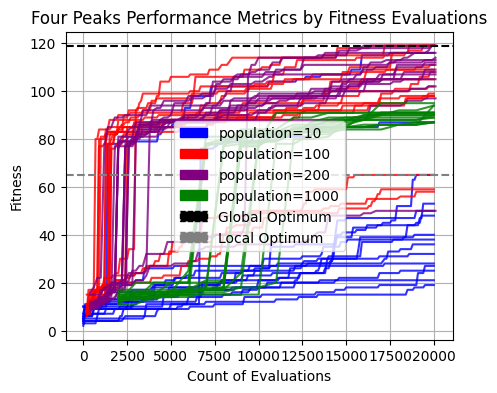

In [181]:
exp1.plot_results()

## Grid search

### Genetic algorithms

In [159]:
np.random.seed(2)
random.seed(2)

population_size = [100, 200]
mutation_prob = [.1, .3, .5]
pop_breed_percent = [.5, .7, .9]

d3 = {
    (p, m, b): np.mean([mlrose.genetic_alg(problem, pop_size=p, mutation_prob=m, pop_breed_percent=b, max_iters=20000, max_attempts=1000)[1] for _ in range(10)])
    for p in population_size
    for m in mutation_prob
    for b in pop_breed_percent
}
sorted_results = [(k, v) for k, v in sorted(d3.items(), key = lambda x: -x[1])]
sorted_results

[((200, 0.5, 0.9), 113.3),
 ((200, 0.5, 0.7), 112.0),
 ((200, 0.3, 0.7), 109.5),
 ((200, 0.3, 0.9), 107.4),
 ((100, 0.1, 0.9), 107.1),
 ((200, 0.3, 0.5), 103.8),
 ((200, 0.1, 0.9), 103.2),
 ((200, 0.1, 0.7), 102.8),
 ((200, 0.5, 0.5), 99.2),
 ((100, 0.5, 0.9), 92.0),
 ((100, 0.5, 0.5), 90.1),
 ((200, 0.1, 0.5), 89.9),
 ((100, 0.3, 0.7), 86.6),
 ((100, 0.3, 0.9), 86.6),
 ((100, 0.1, 0.5), 86.1),
 ((100, 0.1, 0.7), 85.4),
 ((100, 0.3, 0.5), 84.9),
 ((100, 0.5, 0.7), 81.2)]

### simulated annealing

In [160]:
np.random.seed(2)
random.seed(2)
get_tuned_sa = lambda init_temp, decay: mlrose.simulated_annealing(
    problem,
    max_attempts=20_000,
    schedule=GeomDecay(init_temp=init_temp, decay=decay, min_temp=0.001),
    max_iters=20_000
)
init_temps = [3, 2, 1]
decays = [.99, .999, .9999]
d = {(t, d): [get_tuned_sa(t, d)[1] for _ in range(10)] for t in init_temps for d in decays}
sorted_results = [(k, v) for k, v in sorted(d.items(), key = lambda x: -np.sum(x[1]))]
sorted_results

[((2, 0.9999),
  [119.0, 65.0, 65.0, 65.0, 64.0, 65.0, 119.0, 119.0, 65.0, 119.0]),
 ((3, 0.9999),
  [119.0, 119.0, 65.0, 119.0, 119.0, 63.0, 65.0, 65.0, 65.0, 65.0]),
 ((1, 0.9999),
  [65.0, 119.0, 65.0, 119.0, 65.0, 119.0, 65.0, 65.0, 65.0, 65.0]),
 ((1, 0.99), [65.0, 65.0, 119.0, 65.0, 65.0, 65.0, 119.0, 65.0, 65.0, 65.0]),
 ((2, 0.99), [65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 119.0, 65.0, 65.0, 65.0]),
 ((2, 0.999), [65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 119.0]),
 ((3, 0.99), [65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0]),
 ((3, 0.999), [65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0]),
 ((1, 0.999), [65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0])]

In [189]:
np.mean([119.0, 65.0, 65.0, 65.0, 65.0, 65.0, 119.0, 119.0, 65.0, 119.0])

86.6

In [195]:
[(k, np.mean(v), np.sum(np.array(v) > 65)/len(v)) for k, v in sorted(d.items(), key = lambda x: -np.sum(x[1]))]

[((2, 0.9999), 86.5, 0.4),
 ((3, 0.9999), 86.4, 0.4),
 ((1, 0.9999), 81.2, 0.3),
 ((1, 0.99), 75.8, 0.2),
 ((2, 0.99), 70.4, 0.1),
 ((2, 0.999), 70.4, 0.1),
 ((3, 0.99), 65.0, 0.0),
 ((3, 0.999), 65.0, 0.0),
 ((1, 0.999), 65.0, 0.0)]

### random hill climbing, how common to escape?

In [162]:
np.random.seed(2)
random.seed(2)
rhc_trials = Counter([mlrose.random_hill_climb(problem, max_attempts=20_000, max_iters=20_000)[1] for _ in range(100)])
rhc_trials

Counter({65.0: 100})

## final comparisons

genetic is 
((200, 0.5, 0.9), 113.3)
population = 200
mutations = .5
breeding = .9

simulated annealing is
(2, 0.9999)

In [182]:
np.random.seed(2)
random.seed(2)

@dataclass
class EvalTimeStats:
    agg_eval_df: pd.DataFrame
    agg_time_df: pd.DataFrame

class RunResults:
    def __init__(self, run_count: int, ms_groupings=20):
        self.run_count = run_count
        self.ms_groupings = ms_groupings
        self.rhc_fn = lambda: mlrose.random_hill_climb(problem, curve=True, max_attempts=20_000, max_iters=20_000)
        self.ga_fn = lambda: mlrose.genetic_alg(problem, curve=True, pop_size=200, mutation_prob=.5, pop_breed_percent=.9, max_iters=20_000, max_attempts=20_000)
        self.sa_fn = lambda: mlrose.simulated_annealing(
            problem,
            max_attempts=10_000,
            schedule=GeomDecay(init_temp=2, decay=0.9999, min_temp=0.001),
            curve=True,
            max_iters=20_000
        )

        rhc_results = self.get_results(self.rhc_fn, self.run_count)
        self.rhc_stats = self.get_eval_time_stats([RunResult(rhc_result, 1000, self.ms_groupings) for rhc_result in rhc_results])
        sa_results = self.get_results(self.sa_fn, self.run_count)
        self.sa_stats = self.get_eval_time_stats([RunResult(sa_result, 1000, self.ms_groupings) for sa_result in sa_results], trunc_time=180)
        ga_results = self.get_results(self.ga_fn, self.run_count)
        self.ga_stats = self.get_eval_time_stats([RunResult(ga_result, 1000, self.ms_groupings) for ga_result in ga_results], trunc_time=600)

    def get_results(self, fn, count):
        results = []
        for _ in range(count):
            results.append(fn())
        return results
    
    def plot_evals(self):
        sa_eval_df = self.sa_stats.agg_eval_df
        rhc_eval_df = self.rhc_stats.agg_eval_df
        ga_eval_df = self.ga_stats.agg_eval_df

        plt.figure(figsize=(5,4))
        plt.plot(sa_eval_df.index, sa_eval_df['median'], label='Simulated Annealing', color='blue')
        plt.fill_between(sa_eval_df.index, sa_eval_df['min'], sa_eval_df['max'], color='blue', alpha=0.2)
        plt.plot(rhc_eval_df.index, rhc_eval_df['median'], label='Random Hill Climbing', color='red')
        plt.fill_between(rhc_eval_df.index, rhc_eval_df['min'], rhc_eval_df['max'], color='red', alpha=0.2)
        plt.plot(ga_eval_df.index, ga_eval_df['median'], label='Genetic Algorithm', color='green')
        plt.fill_between(ga_eval_df.index, ga_eval_df['min'], ga_eval_df['max'], color='green', alpha=0.2)
        plt.axhline(y=optimal_solution, color='black', linestyle='--', label='Global Optimum')
        plt.axhline(y=length, color = 'grey', linestyle='--', label='Local Optimum')
        plt.title('Four peaks Performance Metrics by Fitness Evaluations')
        plt.xlabel('Count of Evaluations')
        plt.ylabel('Fitness')
        plt.legend()
        plt.grid(True)
        # save figure
        plt.savefig('four_peaks_evals.png')
        plt.show()

    def plot_times(self):
        sa_time_df = self.sa_stats.agg_time_df
        rhc_time_df = self.rhc_stats.agg_time_df
        ga_time_df = self.ga_stats.agg_time_df

        plt.figure(figsize=(5, 4))
        plt.plot(sa_time_df.index, sa_time_df['median'], label='Simulated Annealing', color='blue')
        plt.fill_between(sa_time_df.index, sa_time_df['min'], sa_time_df['max'], color='blue', alpha=0.2)
        plt.plot(rhc_time_df.index, rhc_time_df['median'], label='Random Hill Climbing', color='red')
        plt.fill_between(rhc_time_df.index, rhc_time_df['min'], rhc_time_df['max'], color='red', alpha=0.2)
        plt.plot(ga_time_df.index, ga_time_df['median'], label='Genetic Algorithm', color='green')
        plt.fill_between(ga_time_df.index, ga_time_df['min'], ga_time_df['max'], color='green', alpha=0.2)
        # add a horizontal line at 999 to indicate the optimal possible solution
        plt.axhline(y=optimal_solution, color='black', linestyle='--', label='Global Optimum')
        plt.axhline(y=length, color = 'grey', linestyle='--', label='Local Optimum')
        plt.title('Four peaks Performance Metrics by Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Fitness')
        plt.legend()
        plt.grid(True)
        # save figure
        plt.savefig('four_peaks_time.png')
        plt.show()
    
    def get_eval_time_stats(self, run_results: list[RunResult], trunc_time=4000) -> EvalTimeStats:
        combined_evals = pd.concat([run_result.df_evals for run_result in run_results], axis=1)
        combined_times = pd.concat([run_result.df_times for run_result in run_results], axis=1)
        # filter agg_eval_df to only go up to index of 100,000
        agg_eval_df = pd.DataFrame({
            "min": combined_evals.min(axis=1),
            "median": combined_evals.median(axis=1),
            "max": combined_evals.max(axis=1)
        }).sort_index().loc[:20_000]
        agg_time_df = pd.DataFrame({
            "min": combined_times.min(axis=1),
            "median": combined_times.median(axis=1),
            "max": combined_times.max(axis=1)
        }).sort_index().loc[:trunc_time]
        return EvalTimeStats(agg_eval_df, agg_time_df)
    
res = RunResults(15)

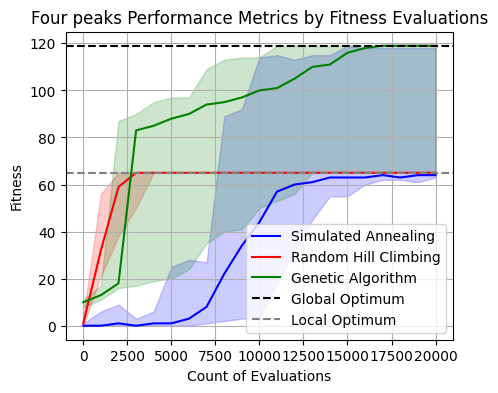

In [183]:
res.plot_evals()

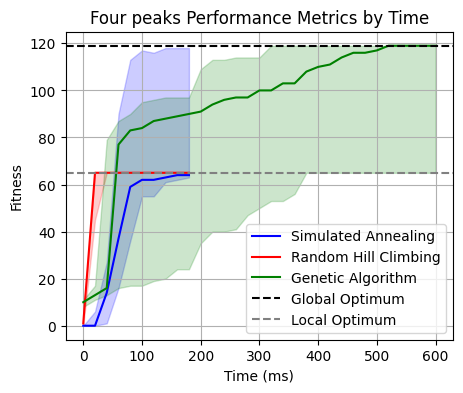

In [184]:
res.plot_times()